# TQuant Lab ARIMA-GARCH 策略，利用時序模型進行股票預測與交易策略

重點摘要：
- 利用Pipeline的Custom Factor寫出單根檢定以及模型。

- 利用預測的報酬率形成交易訊號判別進場、出場時機。

- 以 TQuant Lab 回測平台撰寫交易策略並回測風險與績效。

前言：

在金融市場中，精確的價格預測和有效的交易策略是投資成功的關鍵。本文介紹了一個利用ADF檢定（Augmented Dickey-Fuller Test）和ARIMA-GARCH模型進行股票價格預測的策略。ADF檢定用於測試時間序列的平穩性，而ARIMA-GARCH模型則結合了自回歸整合移動平均模型（ARIMA）和廣義自回歸條件異方差模型（GARCH），以捕捉股票收益率的波動性。本文詳細描述了策略的實現方法和邏輯，並提供了該策略在實際應用中的潛力。

In [17]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
os.environ['TEJAPI_KEY'] = 'SZf1BjNEcKQhvQmn96eLrNL60Q2RH1'
os.environ['TEJAPI_BASE'] = 'https://api.tej.com.tw'

In [18]:
font_path_microsoft = r'C:\Users\User\Desktop\CODE\tej\微軟正黑體 1.ttf'
font_path_arial = r'C:\Users\User\Desktop\CODE\tej\Arial Unicode MS.ttf'

if os.path.isfile(font_path_microsoft):
    matplotlib.font_manager.fontManager.addfont(font_path_microsoft)
if os.path.isfile(font_path_arial):
    matplotlib.font_manager.fontManager.addfont(font_path_arial)
matplotlib.rc('font', family='sans-serif')

In [19]:
start='2021-01-01'
end='2023-12-29'
from logbook import Logger, StderrHandler, INFO
log_handler = StderrHandler(format_string='[{record.time:%Y-%m-%d %H:%M:%S.%f}]: ' +
                            '{record.level_name}: {record.func_name}: {record.message}',
                            level=INFO)
log_handler.push_application()
log = Logger('get_universe')

In [20]:
from zipline.sources.TEJ_Api_Data import get_universe

pool = get_universe(start='2021-01-01',
                    end='2023-12-29',
                    mkt_bd_e = 'TSE', 
                    stktp_e = 'Common Stock',
                    main_ind_c = 'M2300 電子工業'
                    ) 

[2024-07-02 05:07:00.623033]: INFO: get_universe_TW: Filters：{'mkt_bd_e': 'TSE', 'stktp_e': 'Common Stock', 'main_ind_c': 'M2300 電子工業'}


Currently used TEJ API key call quota 47/9223372036854775807 (0.0%)
Currently used TEJ API key data quota 2985334/9223372036854775807 (0.0%)


In [21]:
print(f'共有 {len(pool)} 檔股票：\n', pool)

共有 418 檔股票：
 ['1471', '1582', '2059', '2301', '2302', '2303', '2305', '2308', '2312', '2313', '2314', '2316', '2317', '2321', '2323', '2324', '2327', '2328', '2329', '2330', '2331', '2332', '2337', '2338', '2340', '2342', '2344', '2345', '2347', '2349', '2351', '2352', '2353', '2354', '2355', '2356', '2357', '2359', '2360', '2362', '2363', '2364', '2365', '2367', '2368', '2369', '2373', '2374', '2375', '2376', '2377', '2379', '2380', '2382', '2383', '2385', '2387', '2388', '2390', '2392', '2393', '2395', '2397', '2399', '2401', '2402', '2404', '2405', '2406', '2408', '2409', '2412', '2413', '2414', '2415', '2417', '2419', '2420', '2421', '2423', '2424', '2425', '2426', '2427', '2428', '2429', '2430', '2431', '2433', '2434', '2436', '2438', '2439', '2440', '2441', '2442', '2444', '2448', '2449', '2450', '2451', '2453', '2454', '2455', '2456', '2457', '2458', '2459', '2460', '2461', '2462', '2464', '2465', '2466', '2467', '2468', '2471', '2472', '2474', '2476', '2477', '2478', '2480', '2

In [22]:
os.environ['mdate'] = start + ' ' + end
os.environ['ticker'] = ' 2330 2317 2454 2412 2308 2303 3711 3045 2382 3008' + ' ' + 'IR0001'
!zipline ingest -b tquant

Merging daily equity files:
Currently used TEJ API key call quota 51/9223372036854775807 (0.0%)
Currently used TEJ API key data quota 3283685/9223372036854775807 (0.0%)


[2024-07-02 05:07:10.425360] INFO: zipline.data.bundles.core: Ingesting tquant.
[2024-07-02 05:07:13.578221] INFO: zipline.data.bundles.core: Ingest tquant successfully.


In [23]:
from zipline.pipeline import Pipeline, CustomFactor
from zipline.pipeline.data import TWEquityPricing
from zipline.TQresearch.tej_pipeline import run_pipeline
from zipline import run_algorithm
from zipline.pipeline import CustomFactor, Pipeline
from zipline.pipeline.filters import StaticAssets
from zipline.api import *

In [24]:
# 對數報酬
class LogReturns(CustomFactor):
    inputs = [TWEquityPricing.close]
    window_length = 2

    def compute(self, today, assets, out, close):
        out[:] = np.log(close[-1] / close[-2])

In [25]:
from statsmodels.tsa.stattools import adfuller
# 單根檢定
class ADFTest(CustomFactor):
    inputs = [LogReturns()]
    window_length = 91  

    def compute(self, today, assets, out, close):
        for i in range(len(assets)):
            asset_close = close[:, i]
            valid_idx = ~np.isnan(asset_close)
            asset_close = asset_close[valid_idx]
            if len(asset_close) < 2:
                out[i] = 1.0  # 非定態
                continue

            log_returns = np.log(asset_close[1:] / asset_close[:-1])
            if len(log_returns) < 90:
                out[i] = 1.0  
                continue

            dftest = adfuller(log_returns, autolag="AIC")
            p_value = dftest[1]
            out[i] = p_value

In [26]:
from zipline.data import bundles
bundle_data = bundles.load('tquant')
asset_finder = bundle_data.asset_finder
benchmark_asset = asset_finder.lookup_symbol('IR0001', as_of_date=None)

In [27]:
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from tqdm import tqdm
# 模型預測
class ARIMA_GARCH_Forecast(CustomFactor):
    inputs = [TWEquityPricing.close]
    window_length = 90
    window_safe = True

    def compute(self, today, assets, out, close):
        for i in tqdm(range(len(assets)), desc="Processing Assets"):
            asset_close = close[:, i]
            if np.isnan(asset_close).any() or len(asset_close) < 90:
                out[i] = np.nan
                continue

            asset_close = asset_close[~np.isnan(asset_close)]
            if len(asset_close) < 90:
                out[i] = np.nan
                continue

            asset_log_returns = np.log(asset_close[1:] / asset_close[:-1])
            if np.isnan(asset_log_returns).any():
                out[i] = np.nan
                continue

            try:
                # 檢查是否是常數
                if np.all(asset_log_returns == asset_log_returns[0]):
                    out[i] = np.nan
                    continue

                # ADF test for stationarity
                d = 0
                dftest = adfuller(asset_log_returns, autolag="AIC")
                if dftest[1] > 0.05:
                    asset_log_returns = np.diff(asset_log_returns)
                    d = 1

                model = ARIMA(asset_log_returns, order=(1, d, 1)).fit()
                fc = model.predict(start=0, end=len(asset_log_returns) - 1)
                
                resid = model.resid
                
                garch = arch_model(resid, vol='GARCH', p=1, q=1, dist='normal')
                res = garch.fit(disp='off', options={'maxiter': 5000, 'tol': 1e-6})
                prediction = np.sqrt(res.forecast(horizon=1).variance.values[-1, 0])
                out[i] = fc[-1] + prediction  
            except Exception as e:
                out[i] = np.nan
                print(f"ARIMA-GARCH model error for asset {assets[i]}: {e}")
                print(f"Error details: {str(e)}")

In [28]:
# class RollingSharpeRatioWithForecast(CustomFactor):
#     inputs = [ARIMA_GARCH_Forecast()]
#     window_length = 43
#     window_safe = True

#     def compute(self, today, assets, out, forecasted_log_returns):
#         for i in range(len(assets)):
#             rolling_returns = forecasted_log_returns[:, i]
#             mean_return = np.nanmean(rolling_returns)
#             std_return = np.nanstd(rolling_returns)
#             if std_return == 0:
#                 out[i] = np.nan
#             else:
#                 out[i] = mean_return / std_return

In [29]:
def make_pipeline():
    return Pipeline(
        columns={
            'open': TWEquityPricing.open.latest,
            'close': TWEquityPricing.close.latest,
            'log_returns':LogReturns(),
            'fc_log_returns': ARIMA_GARCH_Forecast()
        },
        screen=~StaticAssets([benchmark_asset]) # 排除大盤的數據
    )

In [30]:
pipeline = make_pipeline()
result = run_pipeline(pipeline, start, end)
result

Processing Assets: 0it [00:00, ?it/s]
Processing Assets:  91%|█████████ | 10/11 [00:00<00:00,  9.97it/s]c:\Users\User\anaconda3\anaconda\envs\tej\lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Processing Assets:  18%|█▊        | 2/11 [00:00<00:00, 13.63it/s]

ARIMA-GARCH model error for asset 0: LU decomposition error.
Error details: LU decomposition error.


Processing Assets:  18%|█▊        | 2/11 [00:00<00:01,  7.46it/s]c:\Users\User\anaconda3\anaconda\envs\tej\lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Processing Assets:  91%|█████████ | 10/11 [00:00<00:00, 11.77it/s]c:\Users\User\anaconda3\anaconda\envs\tej\lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Processing Assets:  55%|█████▍    | 6/11 [00:00<00:00, 10.75it/s]c:\Users\User\anaconda3\anaconda\envs\tej\lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Processi

open    close  log_returns  \
2021-01-05 00:00:00+00:00 Equity(0 [2303])    46.15    45.55          NaN   
                          Equity(1 [2308])   263.50   265.00          NaN   
                          Equity(2 [2317])    93.40    99.90          NaN   
                          Equity(3 [2330])   530.00   536.00          NaN   
                          Equity(4 [2382])    80.40    81.10          NaN   
...                                             ...      ...          ...   
2023-12-29 00:00:00+00:00 Equity(5 [2412])   119.00   120.00     0.004175   
                          Equity(6 [2454])  1045.00  1025.00    -0.014528   
                          Equity(7 [3008])  2815.00  2795.00    -0.005352   
                          Equity(8 [3045])    98.20    98.80     0.005074   
                          Equity(9 [3711])   134.00   135.50     0.014870   

                                            fc_log_returns  
2021-01-05 00:00:00+00:00 Equity(0 [2303])             NaN  
                          Equity(1 [2308])             NaN  
                          Equity(2 [2317])             NaN  
                          Equity(3 [2330])             NaN  
                          Equity(4 [2382])             NaN  
...                                                    ...  
2023-12-29 00:00:00+00:00 Equity(5 [2412])        0.005308  
                          Equity(6 [2454])        0.015908  
                          Equity(7 [3008])        0.022749  
                          Equity(8 [3045])        0.005547  
                          Equity(9 [3711])        0.016558  

[7280 rows x 4 columns]

In [37]:
from zipline.finance import slippage, commission
from zipline.api import set_slippage, set_commission, set_benchmark, attach_pipeline, order_target_percent, symbol, pipeline_output, record, get_datetime, schedule_function, date_rules, time_rules

def initialize(context):
    context.current_stocks = [] 
    context.ban_list = set() 
    set_slippage(slippage.VolumeShareSlippage())
    set_commission(commission.PerShare(cost = 0.001425 + 0.003 / 2))
    attach_pipeline(make_pipeline(), 'mystrats')
    set_benchmark(symbol('IR0001'))

In [38]:
def handle_data(context, data):
    out_dir = pipeline_output('mystrats')
    # 移除 NaN 值
    out_dir = out_dir.dropna(subset=['fc_log_returns'])

    if not context.current_stocks:
        buy_candidates = out_dir.sort_values(by='fc_log_returns', ascending=False).head(3)
        
        if buy_candidates.empty:
            print("No stocks selected for initial buying.")
            return

        current_date = get_datetime().strftime('%Y-%m-%d')
        print(f"Initial Rebalance on {current_date}")
        print(f"Initial Buy Candidates:\n{buy_candidates}")

        buy_weight = 1.0 / len(buy_candidates)
        for stock in context.portfolio.positions:
            order_target_percent(stock, 0)
        for i in buy_candidates.index:
            sym = i.symbol
            close = out_dir.loc[i, "close"]
            fc_log_returns = out_dir.loc[i, 'fc_log_returns']
            
            print(f"Buying {sym} with weight {buy_weight:.2f}")
            order_target_percent(i, buy_weight)

            record(
                **{
                    f'price_{sym}': close,
                    f'fc_log_return_{sym}': fc_log_returns,
                    f'buy_{sym}': True
                }
            )
        context.current_stocks = buy_candidates.index.tolist()
    else:
        for stock in list(context.current_stocks):
            if stock in context.portfolio.positions:
                position = context.portfolio.positions[stock]
                returns = (position.last_sale_price - position.cost_basis) / position.cost_basis

                if returns < 0:  
                    print(f"Selling {stock.symbol} due to returns < 0")
                    order_target_percent(stock, 0)
                    context.current_stocks.remove(stock)
                    context.ban_list.add(stock)  

        out_dir = pipeline_output('mystrats')
        out_dir = out_dir.dropna(subset=['fc_log_returns'])
        out_dir = out_dir[~out_dir.index.isin(context.current_stocks) & ~out_dir.index.isin(context.ban_list)]
        
        new_candidates = out_dir.sort_values(by='fc_log_returns', ascending=False).head(3 - len(context.current_stocks))
        
        for new_stock in new_candidates.index:
            context.current_stocks.append(new_stock)
        
        # 重新計算權重
        buy_weight = 1.0 / len(context.current_stocks)
        for stock in context.current_stocks:
            order_target_percent(stock, buy_weight)

            if stock in new_candidates.index:
                close = new_candidates.loc[stock, "close"]
                fc_log_returns = new_candidates.loc[stock, 'fc_log_returns']

                print(f"Buying {stock.symbol} with weight {buy_weight:.2f}")
                record(
                    **{
                        f'price_{stock.symbol}': close,
                        f'fc_log_return_{stock.symbol}': fc_log_returns,
                        f'buy_{stock.symbol}': True
                    }
                )
    context.ban_list.clear()

In [39]:
import matplotlib.pyplot as plt
capital_base = 100000  # 設定初始資金
def analyze(context, results):
    plt.style.use('ggplot')
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    results['benchmark_cum'] = results.benchmark_return.add(1).cumprod() * capital_base
    results[['portfolio_value', 'benchmark_cum']].plot(ax = ax1, label = 'Portfolio Value($)')
    ax1.set_ylabel('Portfolio value (TWD)')

    plt.legend(loc = 'upper left')

    plt.gcf().set_size_inches(18, 8)
    plt.grid()
    plt.show()

Processing Assets: 100%|██████████| 11/11 [00:01<00:00, 10.10it/s]


Initial Rebalance on 2022-01-03
Initial Buy Candidates:
                    open   close  log_returns  fc_log_returns
Equity(6 [2454])  1200.0  1190.0     0.004211        0.024137
Equity(7 [3008])  2405.0  2465.0     0.024642        0.021058
Equity(0 [2303])    65.1    65.0     0.000000        0.017289
Buying 2454 with weight 0.33
Buying 3008 with weight 0.33
Buying 2303 with weight 0.33
Selling 2454 due to returns < 0
Selling 3008 due to returns < 0
Selling 2303 due to returns < 0
Buying 3711 with weight 0.33
Buying 2308 with weight 0.33
Buying 2382 with weight 0.33
Selling 3711 due to returns < 0
Selling 2308 due to returns < 0
Selling 2382 due to returns < 0
Buying 3008 with weight 0.33
Buying 2454 with weight 0.33
Buying 2330 with weight 0.33
Selling 3008 due to returns < 0
Selling 2454 due to returns < 0
Selling 2330 due to returns < 0
Buying 3711 with weight 0.33
Buying 2308 with weight 0.33
Buying 2317 with weight 0.33
Selling 3711 due to returns < 0
Selling 2308 due to returns 

Processing Assets:  91%|█████████ | 10/11 [00:01<00:00,  9.87it/s]c:\Users\User\anaconda3\anaconda\envs\tej\lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Processing Assets:  18%|█▊        | 2/11 [00:00<00:00, 13.08it/s]

ARIMA-GARCH model error for asset 0: LU decomposition error.
Error details: LU decomposition error.


Processing Assets:  18%|█▊        | 2/11 [00:00<00:00,  9.15it/s]c:\Users\User\anaconda3\anaconda\envs\tej\lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Processing Assets:  91%|█████████ | 10/11 [00:00<00:00, 11.74it/s]c:\Users\User\anaconda3\anaconda\envs\tej\lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Processing Assets: 100%|██████████| 11/11 [00:00<00:00, 11.57it/s]


Selling 2308 due to returns < 0
Selling 3711 due to returns < 0
Selling 2382 due to returns < 0
Buying 3008 with weight 0.33
Buying 2454 with weight 0.33
Buying 2303 with weight 0.33
Selling 3008 due to returns < 0
Selling 2454 due to returns < 0
Selling 2303 due to returns < 0
Buying 2308 with weight 0.33
Buying 3711 with weight 0.33
Buying 2382 with weight 0.33
Selling 2308 due to returns < 0
Selling 3711 due to returns < 0
Selling 2382 due to returns < 0
Buying 3008 with weight 0.33
Buying 2454 with weight 0.33
Buying 2330 with weight 0.33
Selling 3008 due to returns < 0
Selling 2454 due to returns < 0
Selling 2330 due to returns < 0
Buying 2308 with weight 0.33
Buying 3711 with weight 0.33
Buying 2382 with weight 0.33
Selling 2308 due to returns < 0
Selling 3711 due to returns < 0
Selling 2382 due to returns < 0
Buying 3008 with weight 0.33
Buying 2454 with weight 0.33
Buying 2330 with weight 0.33
Selling 3008 due to returns < 0
Selling 2454 due to returns < 0
Selling 2330 due to r

[2024-07-02 05:32:49.004722]: INFO: earn_dividends: Equity(9 [3711]), cash_dividend amount: 6.9959828, pay_date: 2022-07-28, div_owed: 2084.8028744


Selling 2303 due to returns < 0
Selling 3711 due to returns < 0
Selling 2382 due to returns < 0
Buying 3008 with weight 0.33
Buying 2454 with weight 0.33
Buying 2330 with weight 0.33
Selling 3008 due to returns < 0
Selling 2454 due to returns < 0
Selling 2330 due to returns < 0
Buying 2303 with weight 0.33
Buying 3711 with weight 0.33
Buying 2382 with weight 0.33
Selling 2303 due to returns < 0
Selling 3711 due to returns < 0
Selling 2382 due to returns < 0
Buying 3008 with weight 0.33
Buying 2454 with weight 0.33
Buying 2317 with weight 0.33
Selling 3008 due to returns < 0
Selling 2454 due to returns < 0
Selling 2317 due to returns < 0
Buying 2303 with weight 0.33
Buying 3711 with weight 0.33
Buying 2382 with weight 0.33
Selling 2303 due to returns < 0
Selling 3711 due to returns < 0
Selling 2382 due to returns < 0
Buying 2308 with weight 0.33
Buying 2454 with weight 0.33
Buying 3008 with weight 0.33
Selling 2308 due to returns < 0
Selling 2454 due to returns < 0
Selling 3008 due to r

Processing Assets:  55%|█████▍    | 6/11 [00:00<00:00, 10.30it/s]c:\Users\User\anaconda3\anaconda\envs\tej\lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Processing Assets: 100%|██████████| 11/11 [00:00<00:00, 11.05it/s]
[2024-07-02 05:35:00.065554]: INFO: earn_dividends: Equity(4 [2382]), cash_dividend amount: 6.6, pay_date: 2022-08-25, div_owed: 2277.0


Selling 3008 due to returns < 0
Selling 2330 due to returns < 0
Selling 2308 due to returns < 0
Buying 2454 with weight 0.33
Buying 2303 with weight 0.33
Buying 3711 with weight 0.33
Selling 2454 due to returns < 0
Selling 2303 due to returns < 0
Selling 3711 due to returns < 0
Buying 3008 with weight 0.33
Buying 2308 with weight 0.33
Buying 2382 with weight 0.33
Selling 3008 due to returns < 0
Selling 2308 due to returns < 0
Selling 2382 due to returns < 0
Buying 2303 with weight 0.33
Buying 2454 with weight 0.33
Buying 3711 with weight 0.33
Selling 2303 due to returns < 0
Selling 2454 due to returns < 0
Selling 3711 due to returns < 0
Buying 3008 with weight 0.33
Buying 2308 with weight 0.33
Buying 2382 with weight 0.33
Selling 3008 due to returns < 0
Selling 2308 due to returns < 0
Selling 2382 due to returns < 0
Buying 3045 with weight 0.33
Buying 2454 with weight 0.33
Buying 2303 with weight 0.33
Selling 3045 due to returns < 0
Selling 2454 due to returns < 0
Selling 2303 due to r

[2024-07-02 05:35:00.390834]: INFO: earn_dividends: Equity(3 [2330]), cash_dividend amount: 2.75, pay_date: 2022-10-13, div_owed: 159.5


Selling 2454 due to returns < 0
Selling 2303 due to returns < 0
Selling 2308 due to returns < 0
Buying 3008 with weight 0.33
Buying 2330 with weight 0.33
Buying 3711 with weight 0.33
Selling 3008 due to returns < 0
Selling 2330 due to returns < 0
Selling 3711 due to returns < 0
Buying 2303 with weight 0.33
Buying 2308 with weight 0.33
Buying 2454 with weight 0.33
Selling 2303 due to returns < 0
Selling 2308 due to returns < 0
Selling 2454 due to returns < 0
Buying 3008 with weight 0.33
Buying 2382 with weight 0.33
Buying 3711 with weight 0.33
Selling 3008 due to returns < 0
Selling 2382 due to returns < 0
Selling 3711 due to returns < 0
Buying 2303 with weight 0.33
Buying 2454 with weight 0.33
Buying 2330 with weight 0.33
Selling 2303 due to returns < 0
Selling 2454 due to returns < 0
Selling 2330 due to returns < 0
Buying 3008 with weight 0.33
Buying 3711 with weight 0.33
Buying 2382 with weight 0.33
Selling 3008 due to returns < 0
Selling 3711 due to returns < 0
Selling 2382 due to r

Processing Assets:  73%|███████▎  | 8/11 [00:00<00:00,  8.76it/s]c:\Users\User\anaconda3\anaconda\envs\tej\lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Processing Assets: 100%|██████████| 11/11 [00:00<00:00, 13.14it/s]


Selling 2454 due to returns < 0
Selling 3008 due to returns < 0
Selling 2303 due to returns < 0
Buying 2330 with weight 0.33
Buying 3711 with weight 0.33
Buying 2308 with weight 0.33
Selling 2330 due to returns < 0
Selling 3711 due to returns < 0
Selling 2308 due to returns < 0
Buying 2454 with weight 0.33
Buying 2303 with weight 0.33
Buying 3008 with weight 0.33
Selling 2454 due to returns < 0
Selling 2303 due to returns < 0
Selling 3008 due to returns < 0
Buying 2330 with weight 0.33
Buying 3711 with weight 0.33
Buying 2308 with weight 0.33
Selling 2330 due to returns < 0
Selling 3711 due to returns < 0
Selling 2308 due to returns < 0
Buying 2303 with weight 0.33
Buying 3008 with weight 0.33
Buying 2454 with weight 0.33
Selling 2303 due to returns < 0
Selling 3008 due to returns < 0
Selling 2454 due to returns < 0
Buying 2330 with weight 0.33
Buying 3711 with weight 0.33
Buying 2308 with weight 0.33
Selling 2330 due to returns < 0
Selling 3711 due to returns < 0
Selling 2308 due to r

[2024-07-02 05:37:11.484656]: INFO: earn_dividends: Equity(3 [2330]), cash_dividend amount: 2.7498207199999998, pay_date: 2023-04-13, div_owed: 184.23798824


Selling 2454 due to returns < 0
Selling 2303 due to returns < 0
Selling 2330 due to returns < 0
Buying 3008 with weight 0.33
Buying 3711 with weight 0.33
Buying 2308 with weight 0.33
Selling 3008 due to returns < 0
Selling 3711 due to returns < 0
Selling 2308 due to returns < 0
Buying 2454 with weight 0.33
Buying 2330 with weight 0.33
Buying 2303 with weight 0.33
Selling 2454 due to returns < 0
Selling 2330 due to returns < 0
Selling 2303 due to returns < 0
Buying 3008 with weight 0.33
Buying 3711 with weight 0.33
Buying 2308 with weight 0.33
Selling 3008 due to returns < 0
Selling 3711 due to returns < 0
Selling 2308 due to returns < 0
Buying 2454 with weight 0.33
Buying 2330 with weight 0.33
Buying 2303 with weight 0.33
Selling 2454 due to returns < 0
Selling 2330 due to returns < 0
Selling 2303 due to returns < 0
Buying 3008 with weight 0.33
Buying 3711 with weight 0.33
Buying 2308 with weight 0.33
Selling 3008 due to returns < 0
Selling 3711 due to returns < 0
Selling 2308 due to r

[2024-07-02 05:37:12.127781]: INFO: earn_dividends: Equity(6 [2454]), cash_dividend amount: 76.00660606, pay_date: 2023-07-20, div_owed: 4636.40296966
[2024-07-02 05:37:12.191513]: INFO: earn_dividends: Equity(9 [3711]), cash_dividend amount: 8.7931696, pay_date: 2023-07-27, div_owed: 2998.4708336000003


Selling 3008 due to returns < 0
Selling 2330 due to returns < 0
Selling 2308 due to returns < 0
Buying 2382 with weight 0.33
Buying 3711 with weight 0.33
Buying 2454 with weight 0.33
Selling 2382 due to returns < 0
Selling 3711 due to returns < 0
Selling 2454 due to returns < 0
Buying 2308 with weight 0.33
Buying 3008 with weight 0.33
Buying 2330 with weight 0.33
Selling 2308 due to returns < 0
Selling 3008 due to returns < 0
Selling 2330 due to returns < 0
Buying 2382 with weight 0.33
Buying 2454 with weight 0.33
Buying 3711 with weight 0.33
Selling 2382 due to returns < 0
Selling 2454 due to returns < 0
Selling 3711 due to returns < 0
Buying 2308 with weight 0.33
Buying 3008 with weight 0.33
Buying 2330 with weight 0.33
Selling 2308 due to returns < 0
Selling 3008 due to returns < 0
Selling 2330 due to returns < 0
Buying 2382 with weight 0.33
Buying 2454 with weight 0.33
Buying 3711 with weight 0.33
Selling 2382 due to returns < 0
Selling 2454 due to returns < 0
Selling 3711 due to r

Processing Assets:   0%|          | 0/11 [00:00<?, ?it/s]c:\Users\User\anaconda3\anaconda\envs\tej\lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Processing Assets:  64%|██████▎   | 7/11 [00:00<00:00, 13.68it/s]c:\Users\User\anaconda3\anaconda\envs\tej\lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Processing Assets: 100%|██████████| 11/11 [00:00<00:00, 11.18it/s]
[2024-07-02 05:38:47.794236]: INFO: earn_dividends: Equity(7 [3008]), cash_dividend amount: 26.5, pay_date: 2023-09-14, div_owed: 636.0


Selling 2382 due to returns < 0
Selling 2454 due to returns < 0
Selling 3008 due to returns < 0
Buying 2308 with weight 0.33
Buying 2330 with weight 0.33
Buying 2317 with weight 0.33
Selling 2308 due to returns < 0
Selling 2330 due to returns < 0
Selling 2317 due to returns < 0
Buying 2382 with weight 0.33
Buying 3711 with weight 0.33
Buying 2454 with weight 0.33
Selling 2382 due to returns < 0
Selling 3711 due to returns < 0
Selling 2454 due to returns < 0
Buying 2308 with weight 0.33
Buying 2317 with weight 0.33
Buying 3008 with weight 0.33
Selling 2308 due to returns < 0
Selling 2317 due to returns < 0
Selling 3008 due to returns < 0
Buying 2382 with weight 0.33
Buying 3711 with weight 0.33
Buying 2454 with weight 0.33
Selling 2382 due to returns < 0
Selling 3711 due to returns < 0
Selling 2454 due to returns < 0
Buying 2308 with weight 0.33
Buying 2317 with weight 0.33
Buying 3008 with weight 0.33
Selling 2308 due to returns < 0
Selling 2317 due to returns < 0
Selling 3008 due to r

[2024-07-02 05:38:47.988265]: INFO: earn_dividends: Equity(3 [2330]), cash_dividend amount: 3.0, pay_date: 2023-10-12, div_owed: 276.0


Selling 2382 due to returns < 0
Selling 3008 due to returns < 0
Selling 2454 due to returns < 0
Buying 3711 with weight 0.33
Buying 2308 with weight 0.33
Buying 2330 with weight 0.33
Selling 3711 due to returns < 0
Selling 2308 due to returns < 0
Selling 2330 due to returns < 0
Buying 2382 with weight 0.33
Buying 3008 with weight 0.33
Buying 2454 with weight 0.33
Selling 2382 due to returns < 0
Selling 3008 due to returns < 0
Selling 2454 due to returns < 0
Buying 2330 with weight 0.33
Buying 2308 with weight 0.33
Buying 3711 with weight 0.33
Selling 2330 due to returns < 0
Selling 2308 due to returns < 0
Selling 3711 due to returns < 0
Buying 2382 with weight 0.33
Buying 3008 with weight 0.33
Buying 2317 with weight 0.33
Selling 2382 due to returns < 0
Selling 3008 due to returns < 0
Selling 2317 due to returns < 0
Buying 2454 with weight 0.33
Buying 2308 with weight 0.33
Buying 2330 with weight 0.33
Selling 2454 due to returns < 0
Selling 2308 due to returns < 0
Selling 2330 due to r

[2024-07-02 05:38:48.590005]: INFO: earn_dividends: Equity(3 [2330]), cash_dividend amount: 3.0, pay_date: 2024-01-11, div_owed: 282.0


Selling 2382 due to returns < 0
Selling 2317 due to returns < 0
Selling 2330 due to returns < 0
Buying 2454 with weight 0.33
Buying 3711 with weight 0.33
Buying 2303 with weight 0.33
Selling 2454 due to returns < 0
Selling 3711 due to returns < 0
Selling 2303 due to returns < 0
Buying 2382 with weight 0.33
Buying 3008 with weight 0.33
Buying 2330 with weight 0.33
Selling 2382 due to returns < 0
Selling 3008 due to returns < 0
Selling 2330 due to returns < 0
Buying 3711 with weight 0.33
Buying 2454 with weight 0.33
Buying 2317 with weight 0.33
Selling 3711 due to returns < 0
Selling 2454 due to returns < 0
Selling 2317 due to returns < 0
Buying 2382 with weight 0.33
Buying 3008 with weight 0.33
Buying 2303 with weight 0.33
Selling 2382 due to returns < 0
Selling 3008 due to returns < 0
Selling 2303 due to returns < 0
Buying 2454 with weight 0.33
Buying 3711 with weight 0.33
Buying 2317 with weight 0.33
Selling 2454 due to returns < 0
Selling 3711 due to returns < 0
Selling 2317 due to r

[2024-07-02 05:38:48.726970]: INFO: handle_simulation_end: Simulated 485 trading days
first open: 2022-01-03 01:01:00+00:00
last close: 2023-12-29 05:30:00+00:00


Selling 2382 due to returns < 0
Selling 3008 due to returns < 0
Selling 3711 due to returns < 0
Buying 2454 with weight 0.33
Buying 2308 with weight 0.33
Buying 2303 with weight 0.33
Selling 2454 due to returns < 0
Selling 2308 due to returns < 0
Selling 2303 due to returns < 0
Buying 3008 with weight 0.33
Buying 2382 with weight 0.33
Buying 3711 with weight 0.33
Selling 3008 due to returns < 0
Selling 2382 due to returns < 0
Selling 3711 due to returns < 0
Buying 2454 with weight 0.33
Buying 2303 with weight 0.33
Buying 2308 with weight 0.33
Selling 2454 due to returns < 0
Selling 2303 due to returns < 0
Selling 2308 due to returns < 0
Buying 3711 with weight 0.33
Buying 3008 with weight 0.33
Buying 2382 with weight 0.33
Selling 3711 due to returns < 0
Selling 3008 due to returns < 0
Selling 2382 due to returns < 0
Buying 2454 with weight 0.33
Buying 2303 with weight 0.33
Buying 2308 with weight 0.33
Selling 2454 due to returns < 0
Selling 2303 due to returns < 0
Selling 2308 due to r

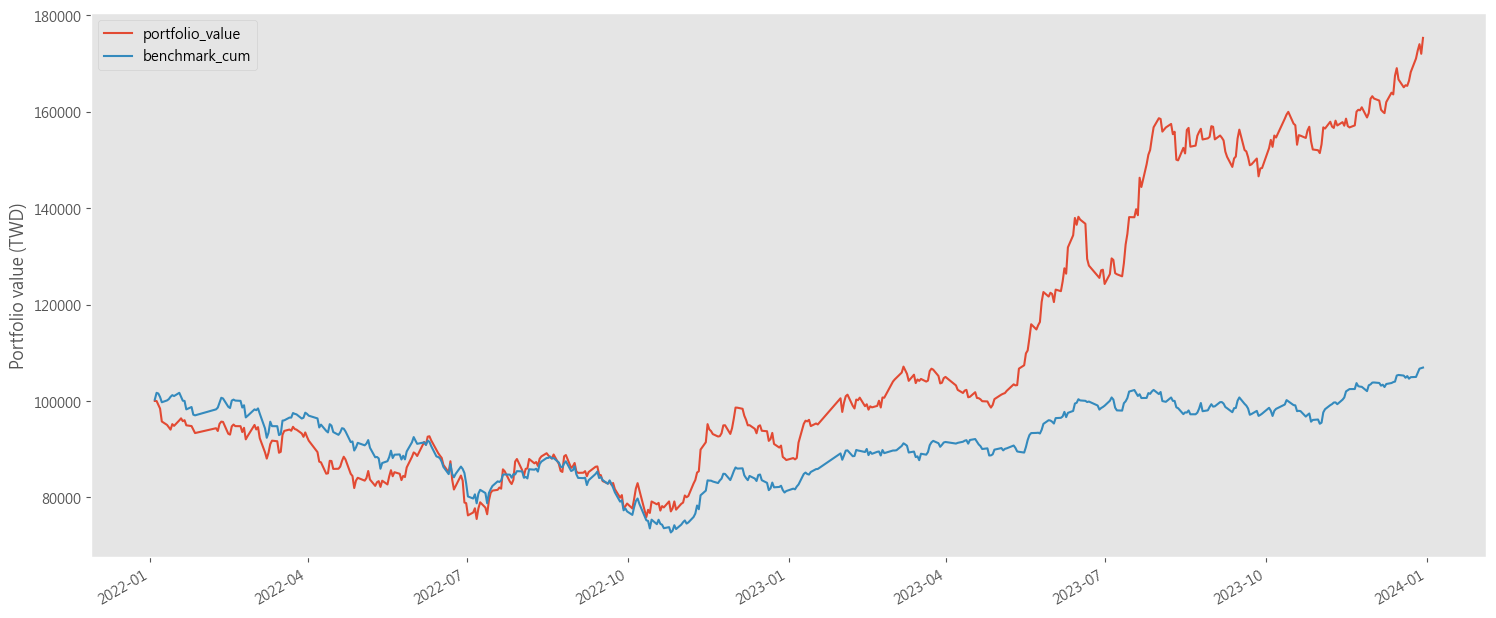

In [40]:
import pytz
start = pd.Timestamp('2022-01-01', tz=pytz.UTC)
end = pd.Timestamp('2023-12-29', tz=pytz.UTC)

results = run_algorithm(
    start=start,
    end=end,
    initialize=initialize,
    handle_data=handle_data, 
    analyze=analyze,
    capital_base=100000,
    data_frequency='daily',
    bundle='tquant'
)

In [43]:
results

,period_open,period_close,capital_used,short_exposure,ending_value,gross_leverage,ending_exposure,transactions,net_leverage,starting_value,...,price_2317,fc_log_return_2317,buy_2317,price_2412,fc_log_return_2412,buy_2412,price_3045,fc_log_return_3045,buy_3045,benchmark_cum
2022-01-03 00:00:00+00:00,2022-01-03 09:01:00+08:00,2022-01-03 13:30:00+08:00,0.000000,0.0,0.0,0.000000,0.0,[],0.000000,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100283.603595
2022-01-04 00:00:00+00:00,2022-01-04 09:01:00+08:00,2022-01-04 13:30:00+08:00,-100731.655550,0.0,100730.0,1.007317,100730.0,"[{'amount': 28, 'dt': 2022-01-04 13:30:00+08:0...",1.007317,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,101687.868911
2022-01-05 00:00:00+00:00,2022-01-05 09:01:00+08:00,2022-01-05 13:30:00+08:00,-389.434139,0.0,100343.0,1.011299,100343.0,"[{'amount': -28, 'dt': 2022-01-05 13:30:00+08:...",1.011299,100730.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,101543.009430
2022-01-06 00:00:00+00:00,2022-01-06 09:01:00+08:00,2022-01-06 13:30:00+08:00,4547.758166,0.0,95000.0,0.965186,95000.0,"[{'amount': -311, 'dt': 2022-01-06 13:30:00+08...",0.965186,100343.0,...,109.0,0.018817,True,NaN,NaN,NaN,NaN,NaN,NaN,100818.296956
2022-01-07 00:00:00+00:00,2022-01-07 09:01:00+08:00,2022-01-07 13:30:00+08:00,-4130.369252,0.0,96448.0,1.007350,96448.0,"[{'amount': -12, 'dt': 2022-01-07 13:30:00+08:...",1.007350,95000.0,...,109.0,0.018817,True,NaN,NaN,NaN,NaN,NaN,NaN,99730.619476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-25 00:00:00+00:00,2023-12-25 09:01:00+08:00,2023-12-25 13:30:00+08:00,-1000.234377,0.0,168083.7,0.982934,168083.7,"[{'amount': -20, 'dt': 2023-12-25 13:30:00+08:...",0.982934,164274.0,...,101.5,0.015508,True,125.0,0.012686,True,94.5,0.297233,True,104981.146130
2023-12-26 00:00:00+00:00,2023-12-26 09:01:00+08:00,2023-12-26 13:30:00+08:00,-99.281132,0.0,169861.5,0.983675,169861.5,"[{'amount': -56, 'dt': 2023-12-26 13:30:00+08:...",0.983675,168083.7,...,101.5,0.015508,True,125.0,0.012686,True,94.5,0.297233,True,105857.497564
2023-12-27 00:00:00+00:00,2023-12-27 09:01:00+08:00,2023-12-27 13:30:00+08:00,-6642.124983,0.0,177800.5,1.021974,177800.5,"[{'amount': -264, 'dt': 2023-12-27 13:30:00+08...",1.021974,169861.5,...,101.5,0.015508,True,125.0,0.012686,True,94.5,0.297233,True,106691.013759
2023-12-28 00:00:00+00:00,2023-12-28 09:01:00+08:00,2023-12-28 13:30:00+08:00,2726.363312,0.0,173080.0,1.006377,173080.0,"[{'amount': -57, 'dt': 2023-12-28 13:30:00+08:...",1.006377,177800.5,...,101.5,0.015508,True,125.0,0.012686,True,94.5,0.297233,True,106803.525440


In [41]:
from pyfolio.utils import extract_rets_pos_txn_from_zipline
import pyfolio as pf

# 從 results 資料表中取出 returns, positions & transactions
returns, positions, transactions = extract_rets_pos_txn_from_zipline(results)  # 從 results 資料表中取出 returns, positions & transactions
benchmark_rets = results.benchmark_return  # 取出 benchmark 的報酬率

<Axes: title={'center': 'Annual returns'}, xlabel='Returns', ylabel='Year'>

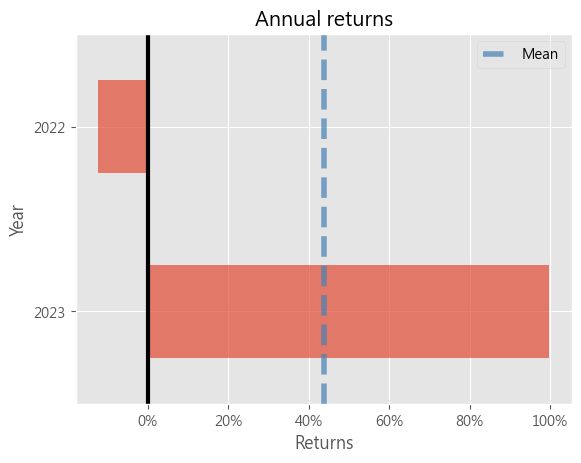

In [45]:
pf.plotting.plot_annual_returns(returns)

Start date,2022-01-03
End date,2023-12-29
Total months,23
,Backtest
Annual return,33.856%
Cumulative returns,75.278%
Annual volatility,25.573%
Sharpe ratio,1.27
Calmar ratio,1.38
Stability,0.73
Max drawdown,-24.469%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,24.47,2022-01-03,2022-07-06,2023-01-30,258
1,10.09,2023-06-15,2023-06-30,2023-07-18,22
2,7.93,2023-03-07,2023-04-26,2023-05-15,46
3,7.60,2023-07-31,2023-09-26,2023-10-12,50
4,5.34,2023-10-13,2023-10-31,2023-11-21,28


Top 10 long positions of all time,max
sid,
2382,36.43%
2454,35.52%
2308,35.51%
2330,35.12%
3008,35.04%
2303,34.84%
3711,34.83%
2412,34.57%
2317,34.46%


Top 10 short positions of all time,max
sid,


Top 10 positions of all time,max
sid,
2382,36.43%
2454,35.52%
2308,35.51%
2330,35.12%
3008,35.04%
2303,34.84%
3711,34.83%
2412,34.57%
2317,34.46%


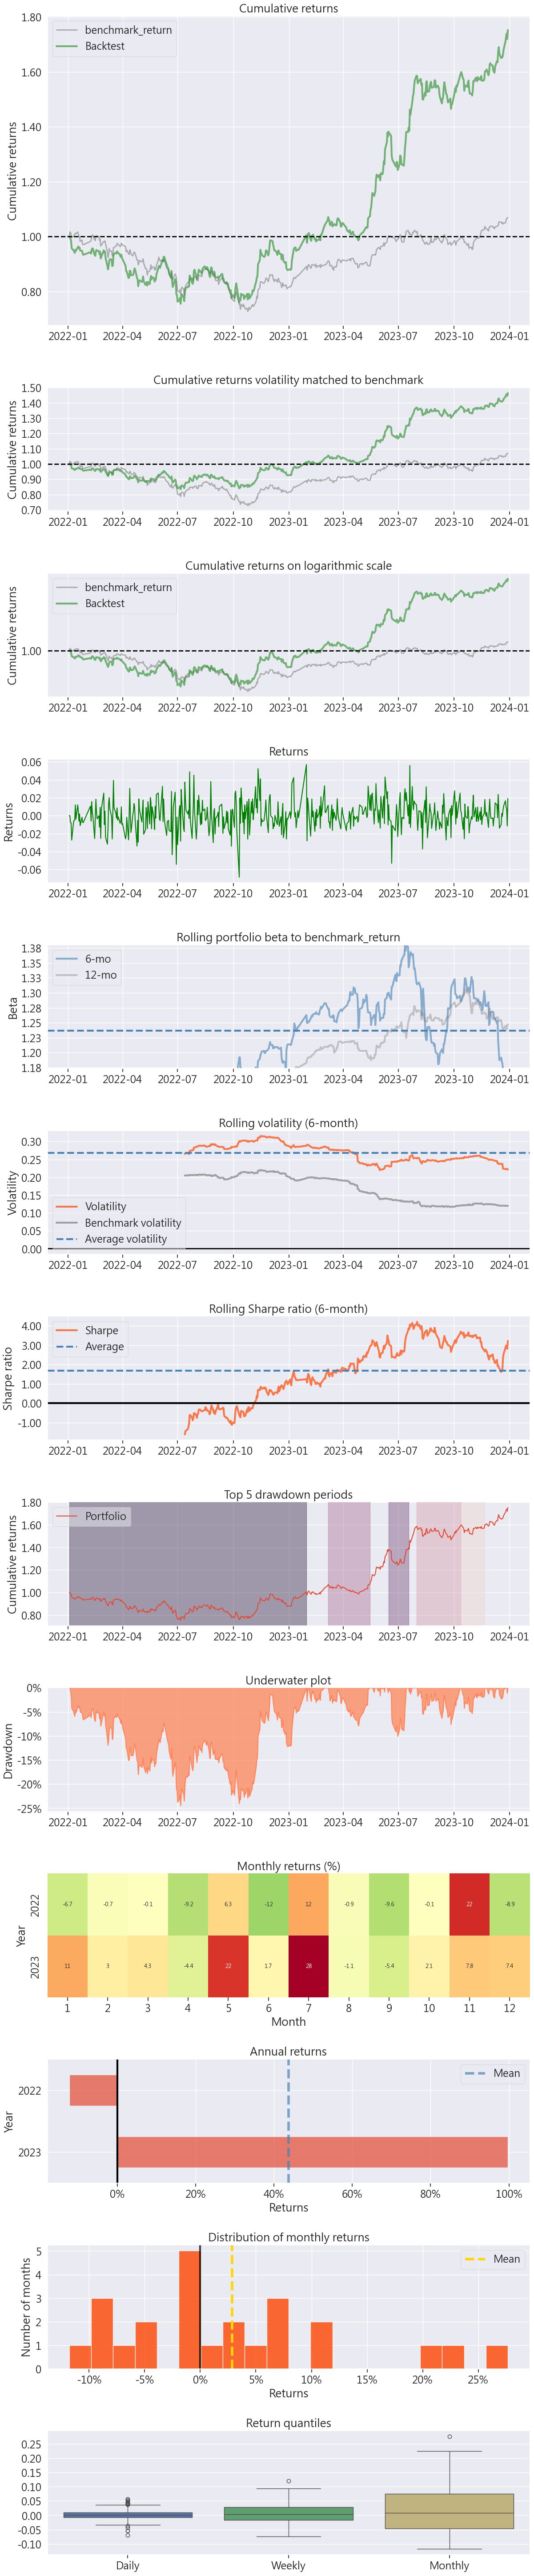

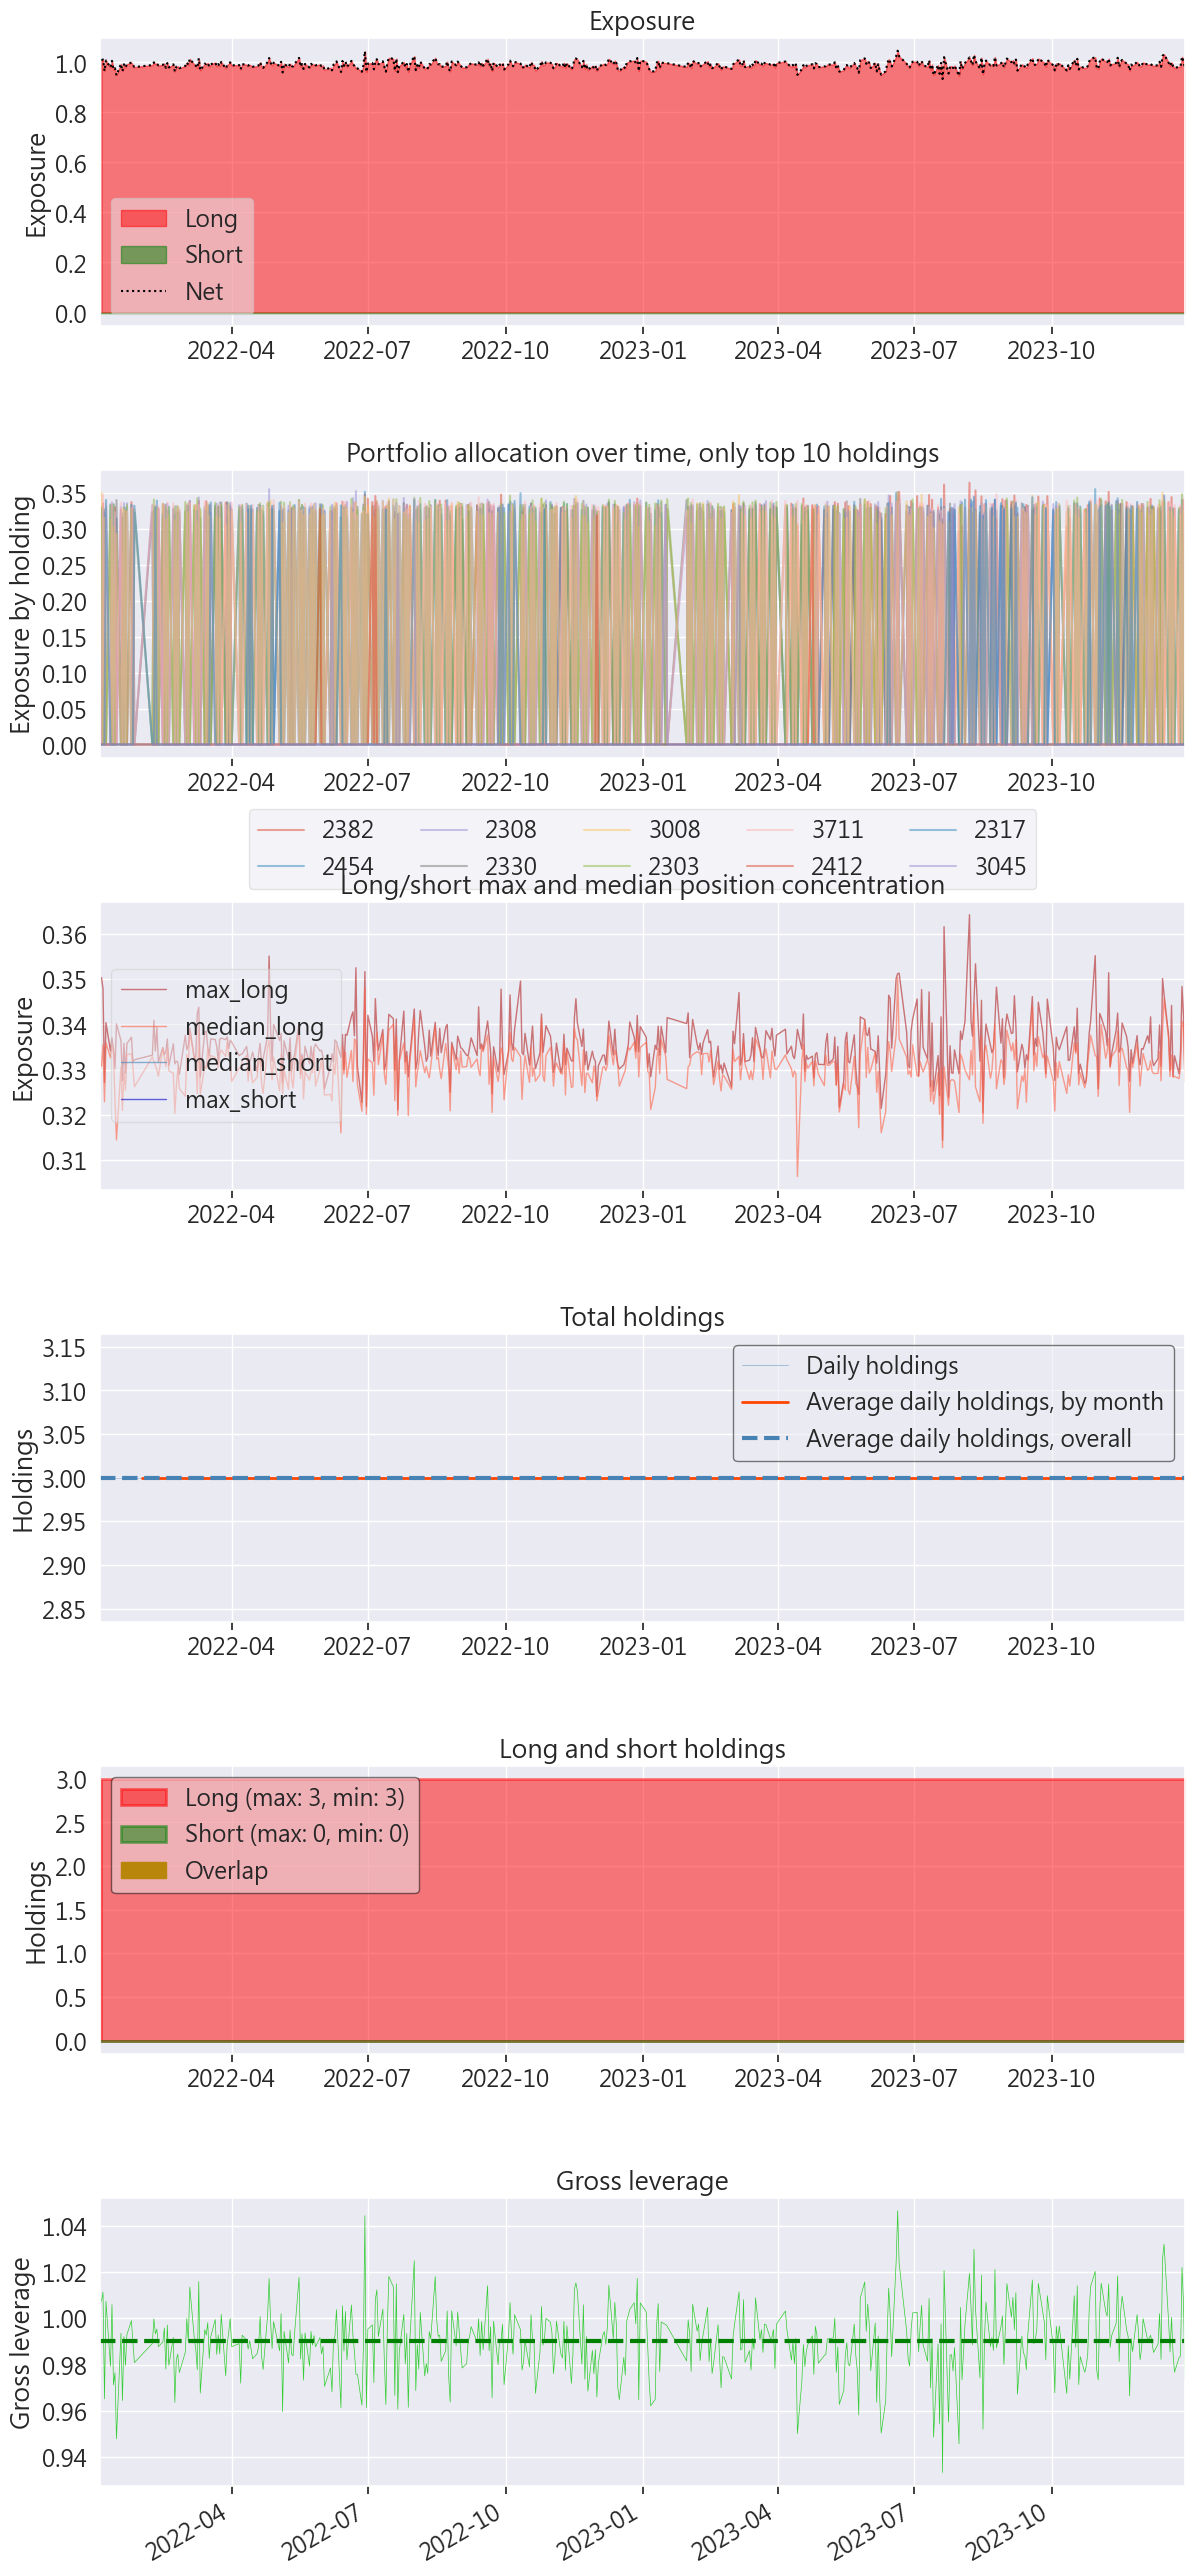

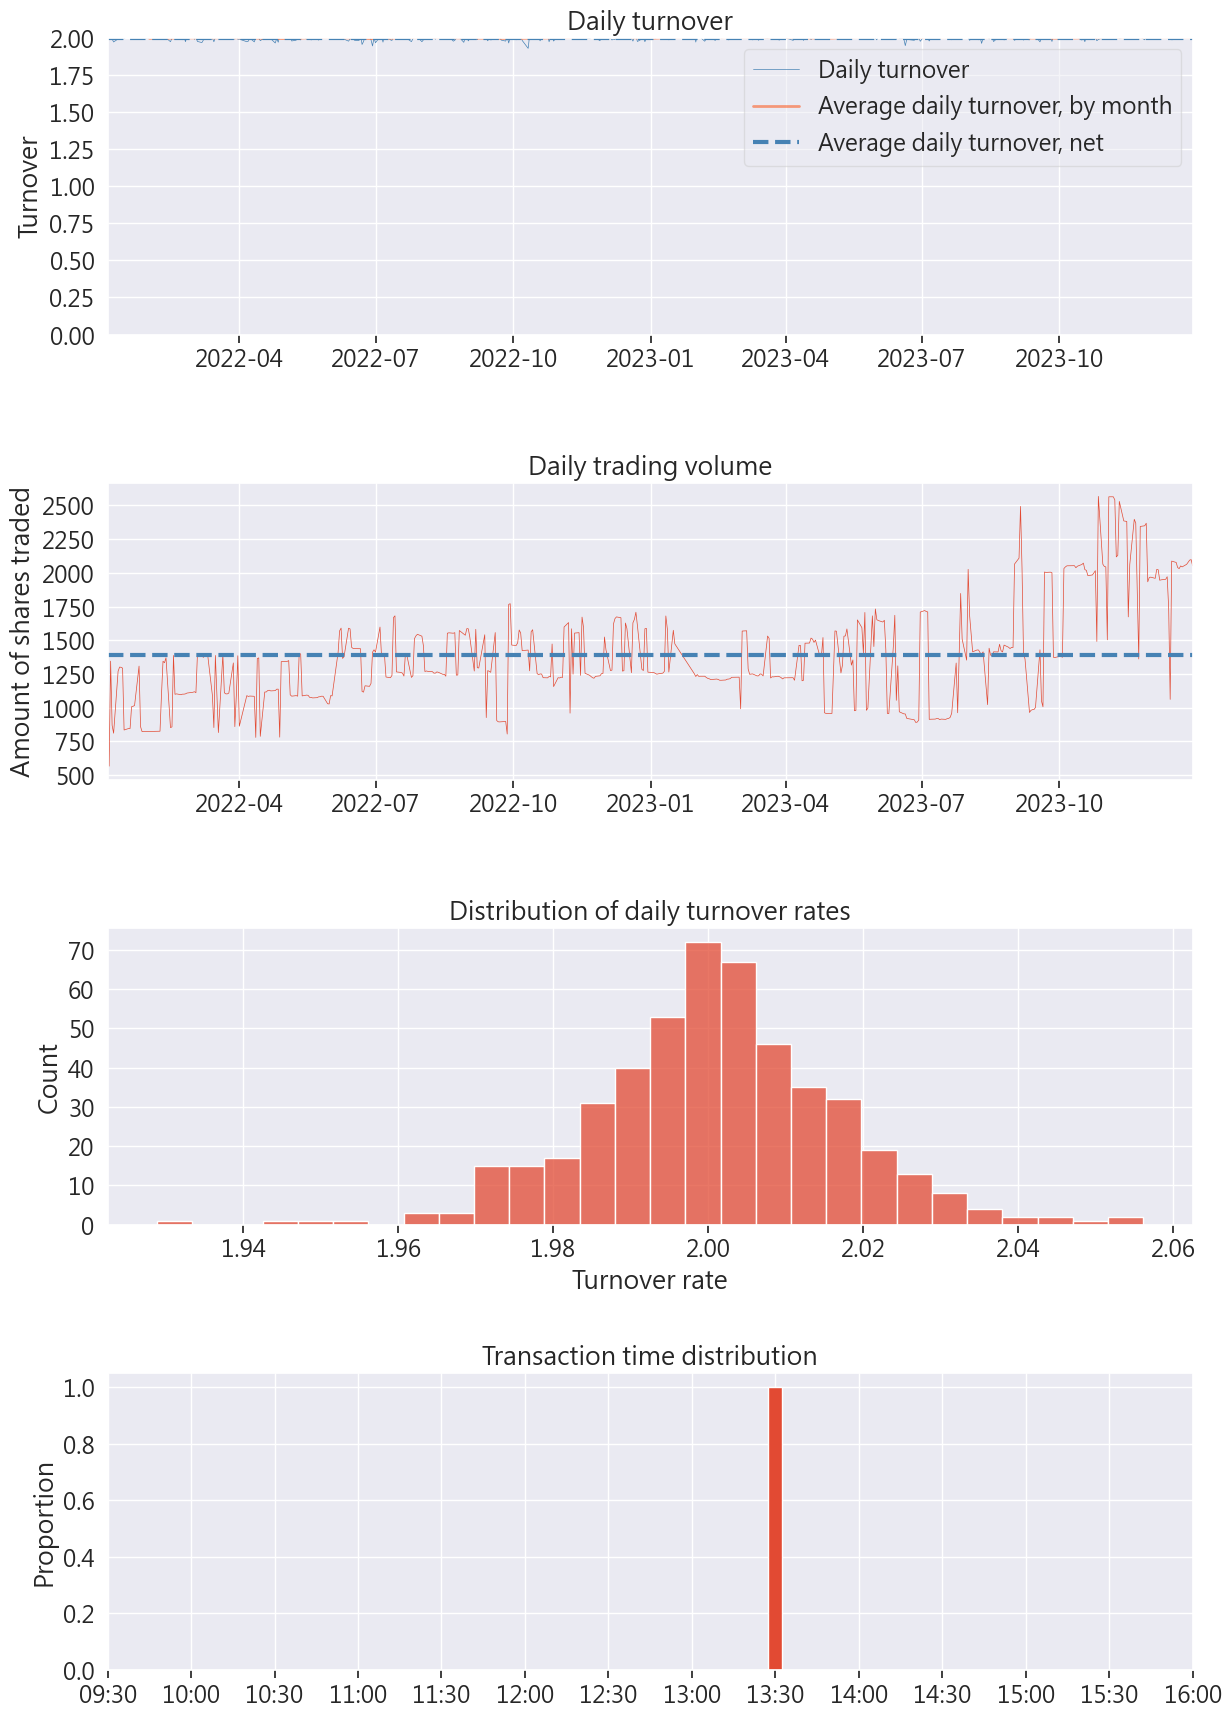

In [42]:
# 繪製 Pyfolio 中提供的所有圖表
pf.tears.create_full_tear_sheet(returns=returns,
                                     positions=positions,
                                     transactions=transactions,
                                     benchmark_rets=benchmark_rets
                                    )